In [ ]:
%%capture
!pip install -U wandb

In [ ]:
import os
import wandb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

os.environ["WANDB_API_KEY"]=...

env: WANDB_API_KEY=a0f2005d28a0d578c0fb9ec3f9f5e9f32b682848


In [ ]:
env_ids = [
    "navix:Navix-Empty-6x6-v0", "navix:Navix-Dynamic-Obstacles-6x6-v0",
    "navix:Navix-LavaGapS6-v0", "navix:Navix-GoToDoor-6x6-v0",
]

In [ ]:

def get_data(sweep_id):

    api = wandb.Api()
    sweep = api.sweep(f"yourweep/{sweep_id}")
    runs = sweep.runs

    data = {
        "env_id": [],
        "Episode_Return": [],
        "env_samples": [],
        "optimiser": [],
        "mlmc": [],
        "seed": [],
        "batchsize_bound": [],
        "batchsize_limit": [],
        "projection": []
    }


    for i in runs:
        run_data = i.history(
            samples=100000, keys=None, x_axis="env_samples", pandas=(True), stream="default"
        )
        try:
            data["Episode_Return"].append(run_data["Episode_Return"].values)
            data["env_samples"].append(run_data["env_samples"].values)
            data["optimiser"].append(i.config["optimiser"])
            data["env_id"].append(i.config["experiment.env_id"])
            data["mlmc"].append(i.config["experiment.mlmc_correction"])
            data["seed"].append(i.config["seed"])
            data["batchsize_bound"].append(i.config["experiment.batchsize_bound"])
            data["batchsize_limit"].append(i.config["experiment.batchsize_limit"])
            data["projection"].append(i.config["experiment.projection"])

        except KeyError as e:
            continue


    return data



In [ ]:
df = pd.DataFrame(get_data("abracadabra"))

In [ ]:
# groups = {
#     ('2', False): "MAdam",
#     ('sf_sgd', False): "Schedule-free SGD",
#     ('adam', False): "Adam",
#     ('prodigy', False): "Prodigy",
#     ('mamd', False): "SGD w/ momentum"
# }

projection = "l2"

# groups = {
#     (2, 2, False, projection): "B=2, M=2, no batching",
#     (2, 2, True, projection): "B=2, M=2, with batching",
#     (2, 32, False, projection): "B=2, M=32, no batching",
#     (2, 32, True, projection): "B=2, M=32, with batching",
#     (64, 32, False, projection): "B=64, M=32, no batching",
#     (64, 32, True, projection): "B=64, M=32, with batching",
#     (64, 2, False, projection): "B=64, M=2, no batching",
#     (64, 2, True, projection): "B=64, M=2, with batching",
# }


# groups = {
#     (2, 2, False, "simplex"): "Bregman entropy projection",
#     (2, 2, False, "l2"): "Euclidean projection",
#     (2, 2, False, "none"): "Softmax projection",

# }

# groups = {
#     (2, 2, True, "simplex"): "Bregman entropy projection",
#     (2, 2, True, "l2"): "Euclidean projection",
#     (2, 2, True, "none"): "Softmax projection",

# }

groups = {
    (2, 2, True, "simplex"): "batching + Bregman projection",
    (2, 2, False, "simplex"): "no batching + Bregman projection",
}


titles = {
    "navix:Navix-Empty-6x6-v0": r"6 $\times$ 6 Empty Room",
    "navix:Navix-Dynamic-Obstacles-6x6-v0": r"6 $\times$ 6 Room with Dyn. Obstacles",
    "navix:Navix-LavaGapS6-v0": r"6 $\times$ 6 Lava Gap",
    "navix:Navix-GoToDoor-6x6-v0": r"6 $\times$ 6 Go-To-Door"
}

In [ ]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

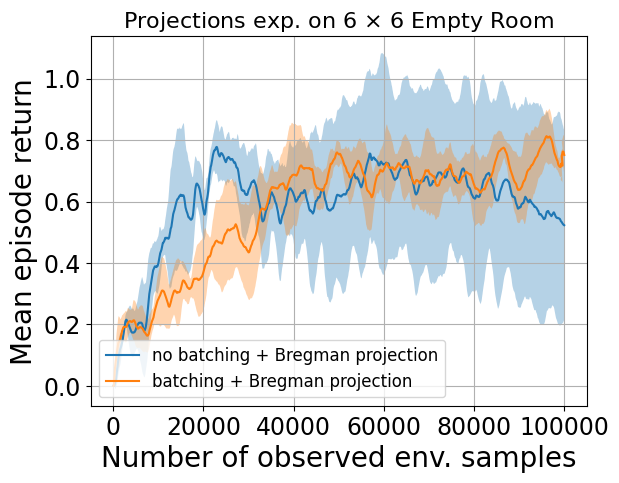

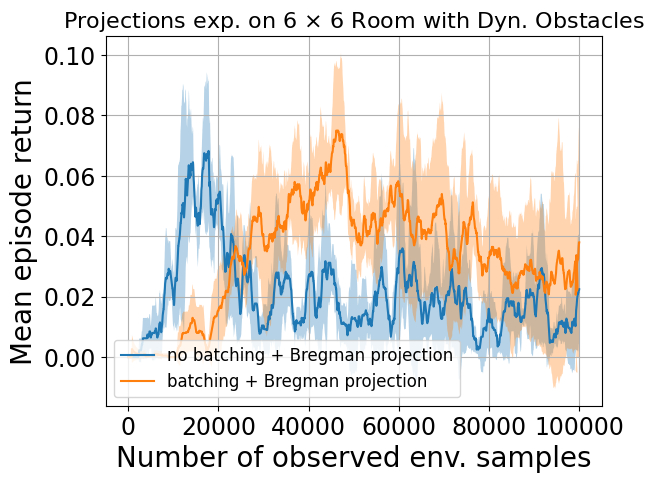

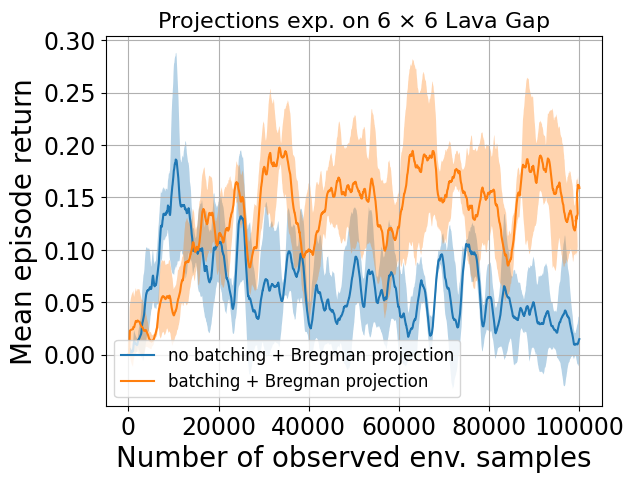

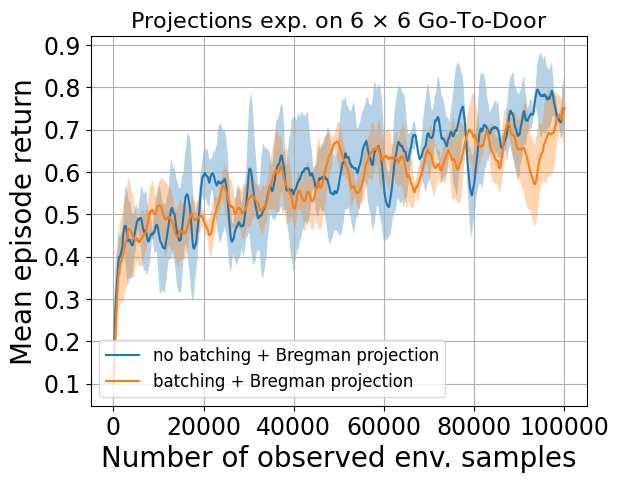

In [ ]:

for env_id in env_ids:

    for gr, arr in df[df['env_id'] == env_id].groupby(["batchsize_bound", "batchsize_limit", "mlmc", "projection"]):

        if gr in groups:
            label = groups[gr]

            mean, sigma = tolerant_mean(arr["Episode_Return"].values)
            x_mean, _ = tolerant_mean(arr["env_samples"].values)

            plt.plot(
                x_mean,
                mean,
                label=label,
                )

            plt.fill_between(
                x_mean,
                mean+sigma,
                mean-sigma,
                alpha=0.33
                )
    plt.grid()
    plt.title(titles[env_id])
    fontsize=16
    plt.title(f"Projections exp. on {titles[env_id]}", fontsize=fontsize)
    plt.xlabel("Number of observed env. samples", fontsize=fontsize+4)
    plt.ylabel("Mean episode return", fontsize=fontsize+4)
    plt.xticks(fontsize=fontsize+1)
    plt.yticks(fontsize=fontsize+1)
    plt.legend(loc="lower left", fontsize=12)
    plt.savefig(f'{env_id}_batching.pdf', format = 'pdf', bbox_inches='tight')
    plt.show()